In [1]:
%cd ~/dissertation_code
import pandas as pd
import numpy as np
import itertools
import json
import matplotlib.pyplot as plt
from bisect import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import ttest_ind
from scipy.interpolate import interp1d

/home/tntech.edu/kebrown46/dissertation_code


In [2]:
datasets = ["trauma_uk", "diabetes", "critical_outcome", "ED_3day_readmit", "hospitalization_prediction"]
# datasets = ["trauma_uk", "diabetes", "critical_outcome"]
models = ["NN-dropout", "catboost-ve"]
res_key = "dissertation_SG"
dt_subgroup_disc=False
eval_combos = list(itertools.product(datasets, models))
print(eval_combos)
alpha_gain = 0.5

[('trauma_uk', 'NN-dropout'), ('trauma_uk', 'catboost-ve'), ('diabetes', 'NN-dropout'), ('diabetes', 'catboost-ve'), ('critical_outcome', 'NN-dropout'), ('critical_outcome', 'catboost-ve'), ('ED_3day_readmit', 'NN-dropout'), ('ED_3day_readmit', 'catboost-ve'), ('hospitalization_prediction', 'NN-dropout'), ('hospitalization_prediction', 'catboost-ve')]


In [3]:
def read_stats_file(cls_model, dataset, res_key = ""):
    if res_key != "":
        return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")
    else:
        return pd.read_csv(f"RQ 3/results/subgroup_statistics_{cls_model}_{dataset}.csv")
        
        
        
def aggregate_across_crossval(cls_model, dataset, n_bins_list, columns_to_average, res_key=""):  
    df = read_stats_file(cls_model, dataset, res_key=res_key)
    results = []
    for n_bins in n_bins_list:
        res = {}
        sub_df = df[(df["n_bins"] == n_bins) & (df["alpha_gain"] == alpha_gain) & (df["min_support"] == 1)]
        print(f"sub_df.shape = {sub_df.shape}")
        res["model"] = cls_model
        res["dataset"] = dataset
        res["no_bins"] = n_bins
        for c in columns_to_average:
            print(sub_df[c])
            if "coverage" == c:
                res[f"{c}"], res[f"{c} std dev"] = get_average_coverage_for_entire_tree(sub_df, res_key=res_key)
            elif "bin distribution" not in c:
                res[f"{c}"] = np.mean(sub_df[c])
                res[f"{c} std dev"] = np.std(sub_df[c])
            
        results.append(res)
    return pd.DataFrame(results)
   
def get_average_coverage_for_entire_tree(sub_df, res_key=""):
    values = []
    for i in range(sub_df.shape[0]):
        row = sub_df.iloc[i]
        no_subgroups = row["no_rules"].astype(int)
        coverage_columns = [f"subgroup {i} size" for i in range(int(no_subgroups))]
        coverage_vals = row[coverage_columns].values
        size = np.sum(coverage_vals)
        coverage_vals /= size
        values.append(np.mean(coverage_vals))
    values = np.asarray(values)
    return np.mean(values), np.std(values)
    
def map_dataset_names_proper(d):
    map_ = {
        "trauma_uk": "Trauma",
        "diabetes": "Diabetes",
        "critical_outcome": "Critical Outcome",
        "ED_3day_readmit": "3-Day Readmit",
        "hospitalization_prediction": "Hospitalization Prediction"
    }
    return map_[d]

def map_model_names_proper(m):
    map_ = {
        "NN-dropout": "ANN",
        "catboost-ve": "GBT"
    }
    return map_[m]

def map_metric_names_proper(m):
    map_ = {
        "coverage": "Coverage",
        "no_rules": "No. Rules",
        "bin assignment accuracy overall": "Bin Assignment Accuracy"
    }
    return map_[m]

def format_values(row, m):
    avg = m
    stdev = f"{m} std dev"
    avg_value = row[avg].values[0]
    stdev_value = row[stdev].values[0]
    # print(f"avg_value = {avg_value}")
    # print(f"stdev_value = {stdev_value}")
    return f"{avg_value} ({stdev_value})"

Code to produce Tables 3 & 4 for AMIA SD-DT Paper
Table 3, $n_{bins} = 2$
| Dataset | Classification Model | No. Rules (std dev)      | Bin Assignment Accuracy (std dev) | Coverage (std dev) | 
|---------|----------------------|--------------------------|-----------------------------------|--------------------|
| Name    |     ANN or GBT       | $\bar{X} (\sigma)$       |            $\bar{X} (\sigma)$     | $\bar{X} (\sigma)$ |

In [4]:
def compute_format_row_table_3_4(dataset, cls_model, n_bins, res_key = ""):
    columns_to_average = ["no_rules", "bin assignment accuracy overall", "coverage"]
    row = aggregate_across_crossval(cls_model, dataset, [n_bins], columns_to_average, res_key=res_key)
    final_row = {}
    final_row["Dataset"] = map_dataset_names_proper(dataset)
    final_row["Classification Model"] = map_model_names_proper(cls_model)
    for m in columns_to_average:
        final_row[map_metric_names_proper(m)] = format_values(row, m)
    # final_row["min coverage"] = row["min coverage"].values[0]
    # final_row["max coverage"] = row["max coverage"].values[0]
    return final_row

def _map_num_to_labels(nums, n_bins):
    dict_ = {0: "Low", 1: "High"} if n_bins == 2 else {0: "Low", 1: "Medium", 2: "High"} 
    return list(map(lambda x: dict_[x], nums))
    
def gather_predictions_10fold_cv(dataset, cls_model, n_bins, res_key=""):
    y_pred = []
    y_true = []
    for i in range(10):
        df = pd.read_csv(f"RQ 3/input/{res_key}/subgroup_assignments_{cls_model}_{dataset}_test_{i}_inf_1_{alpha_gain}_bins{n_bins}.csv")
        y_pred.extend(df["uncertainty_bin_assignments"].astype(int))
        y_true.extend(df["true_uncertainty_bin_assignments"].astype(int))
    y_pred = _map_num_to_labels(y_pred, n_bins)
    y_true = _map_num_to_labels(y_true, n_bins)
    return y_pred, y_true
    
def _confusion_matrix(dataset, cls_model, n_bins, res_key = ""):
    
    labels_ = ["Low", "High"] if n_bins == 2 else ["Low", "Medium", "High"]
    
    predictions, y_test = gather_predictions_10fold_cv(dataset, cls_model, n_bins, res_key)
    print(np.unique(predictions, return_counts=True))
    print(np.unique(y_test, return_counts=True))
    cm = confusion_matrix(y_test, predictions, labels=labels_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_)
    disp.plot()
    d = map_dataset_names_proper(dataset)
    m = map_model_names_proper(cls_model)
    plt.title(f"{d} - {m}")
    plt.savefig(f"RQ 3/results/{res_key}/confusion_matrix_{dataset}_{cls_model}_nbins{n_bins}.png")
    plt.show()            
                

In [5]:
# Table 3
results = []
for dataset, model in eval_combos:
    print(dataset, model)
    r = compute_format_row_table_3_4(dataset, model, 2, res_key = res_key)
    results.append(r)
results = pd.DataFrame(results)
display(results)
results.to_csv(f"RQ 3/results/{res_key}/bin_accuracy_nbins2.csv")
# for dataset, model in eval_combos:
#     print(dataset, model)
#     _confusion_matrix(dataset, model, 2, res_key)

trauma_uk NN-dropout
sub_df.shape = (10, 1449)
4      25.0
52     35.0
100    33.0
148    36.0
196    35.0
244    34.0
292    38.0
340    29.0
388    20.0
436    36.0
Name: no_rules, dtype: float64
4      0.701881
52     0.740025
100    0.743540
148    0.688522
196    0.730884
244    0.782739
292    0.651081
340    0.644401
388    0.645394
436    0.755626
Name: bin assignment accuracy overall, dtype: float64
4      0.091262
52     0.066009
100    0.070559
148    0.081680
196    0.089905
244    0.070025
292    0.073218
340    0.113435
388    0.099524
436    0.094395
Name: coverage, dtype: float64
trauma_uk catboost-ve
sub_df.shape = (10, 1737)
4      52.0
52     48.0
100    55.0
148    44.0
196    57.0
244    50.0
292    54.0
340    45.0
388    39.0
436    42.0
Name: no_rules, dtype: float64
4      0.676217
52     0.678327
100    0.625945
148    0.765688
196    0.609597
244    0.646511
292    0.535243
340    0.786606
388    0.735935
436    0.758790
Name: bin assignment accuracy overall,

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (5569,5570,5578,5579,5587,5588,5596,5597,5605,5606,5614,5615,5623,5624,5632,5633,5641,5642,5650,5651,5659,5660,5668,5669,5677,5678,5686,5687,5695,5696,5704,5705,5713,5714,5722,5723,5731,5732,5740,5741,5749,5750,5758,5759,5767,5768,5776,5777,5785,5786,5794,5795,5803,5804,5812,5813,5821,5822,5830,5831,5839,5840,5848,5849,5857,5858,5866,5867,5875,5876,5884,5885,5893,5894,5902,5903,5911,5912,5920,5921) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


sub_df.shape = (10, 5922)
4      90.0
52     85.0
100    81.0
148    75.0
196    89.0
244    83.0
292    76.0
340    80.0
388    85.0
436    89.0
Name: no_rules, dtype: float64
4      0.809261
52     0.818798
100    0.784637
148    0.832707
196    0.806474
244    0.693594
292    0.791863
340    0.822192
388    0.739687
436    0.738033
Name: bin assignment accuracy overall, dtype: float64
4      0.064314
52     0.054954
100    0.067314
148    0.058124
196    0.065636
244    0.062553
292    0.061298
340    0.056023
388    0.058144
436    0.054820
Name: coverage, dtype: float64
critical_outcome catboost-ve


/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (6361,6362,6370,6371,6379,6380,6388,6389,6397,6398,6406,6407,6415,6416,6424,6425,6433,6434,6442,6443,6451,6452,6460,6461,6469,6470,6478,6479,6487,6488,6496,6497,6505,6506,6514,6515,6523,6524,6532,6533,6541,6542,6550,6551,6559,6560,6568,6569,6577,6578,6586,6587,6595,6596,6604,6605,6613,6614,6622,6623,6631,6632,6640,6641,6649,6650,6658,6659,6667,6668,6676,6677,6685,6686,6694,6695) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


sub_df.shape = (10, 6696)
4      92.0
52     81.0
100    92.0
148    87.0
196    93.0
244    92.0
292    96.0
340    82.0
388    84.0
436    93.0
Name: no_rules, dtype: float64
4      0.713438
52     0.688270
100    0.768168
148    0.780831
196    0.823215
244    0.752401
292    0.731266
340    0.768298
388    0.697053
436    0.707179
Name: bin assignment accuracy overall, dtype: float64
4      0.063667
52     0.068206
100    0.057685
148    0.061576
196    0.057608
244    0.068037
292    0.058123
340    0.063615
388    0.060224
436    0.069120
Name: coverage, dtype: float64
ED_3day_readmit NN-dropout


/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (4606,4607,4615,4616,4624,4625,4633,4634,4642,4643,4651,4652,4660,4661,4669,4670,4678,4679,4687,4688,4696,4697,4705,4706,4714,4715,4723,4724,4732,4733,4741,4742,4750,4751,4759,4760,4768,4769,4777,4778,4786,4787,4795,4796,4804,4805,4813,4814,4822,4823,4831,4832,4840,4841,4849,4850,4858,4859,4867,4868,4876,4877,4885,4886,4894,4895,4903,4904,4912,4913,4921,4922,4930,4931,4939,4940,4948,4949,4957,4958,4966,4967,4975,4976,4984,4985) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


sub_df.shape = (10, 4986)
4      100.0
52      79.0
100     87.0
148     77.0
196     95.0
244    106.0
292     85.0
340     79.0
388     99.0
436    104.0
Name: no_rules, dtype: float64
4      0.635285
52     0.656737
100    0.663216
148    0.704694
196    0.662650
244    0.662717
292    0.705169
340    0.690914
388    0.656593
436    0.730920
Name: bin assignment accuracy overall, dtype: float64
4      0.039548
52     0.040703
100    0.047046
148    0.045918
196    0.040271
244    0.043221
292    0.037556
340    0.043466
388    0.047444
436    0.033691
Name: coverage, dtype: float64
ED_3day_readmit catboost-ve


/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (19,20,28,29,37,38,46,47,55,56,64,65,73,74,82,83,91,92,100,101,109,110,118,119,127,128,136,137,145,146,154,155,163,164,172,173,181,182,190,191,199,200,208,209,217,218,226,227,235,236,244,245,253,254,262,263,271,272,280,281,289,290,298,299,313,314,322,323,331,332,340,341,349,350,358,359,367,368,376,377,385,386,394,395,403,404,412,413,421,422,430,431,439,440,448,449,457,458,466,467,475,476,484,485,493,494,502,503,511,512,520,521,529,530,538,539,547,548,556,557,565,566,574,575,583,584,592,593,601,602,610,611,619,620,628,629,637,638,646,647,655,656,664,665,673,674,682,683,691,692,700,701,709,710,718,719,727,728,736,737,745,746,754,755,763,764,772,773,781,782,790,791,799,800,808,809,817,818,826,827,835,836,844,845,853,854,862,863,871,872,880,881,889,890,898,899,907,908,916,917,925,926,934,935,943,944,952,953,961,962,970,971,979,980,988,989,997,998,1006,1007,1015,1016,1024,1025,1033,1034,1042,1043,1051,1052,1060,1061,1069,1070,1078,1

sub_df.shape = (10, 8334)
4      130.0
52     116.0
100    128.0
148    123.0
196    125.0
244    147.0
292    129.0
340    140.0
388    134.0
436    134.0
Name: no_rules, dtype: float64
4      0.783912
52     0.789620
100    0.766831
148    0.755867
196    0.810733
244    0.812772
292    0.695202
340    0.783023
388    0.768684
436    0.818272
Name: bin assignment accuracy overall, dtype: float64
4      0.046124
52     0.045813
100    0.046859
148    0.050171
196    0.042436
244    0.042004
292    0.051917
340    0.039504
388    0.048647
436    0.045228
Name: coverage, dtype: float64
hospitalization_prediction NN-dropout


/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (3319,3320,3328,3329,3337,3338,3346,3347,3355,3356,3364,3365,3373,3374,3382,3383,3391,3392,3400,3401,3409,3410,3418,3419,3427,3428,3436,3437,3445,3446,3454,3455,3463,3464,3472,3473,3481,3482,3490,3491,3499,3500,3508,3509,3517,3518,3526,3527,3535,3536,3544,3545,3553,3554,3562,3563,3571,3572,3580,3581,3589,3590,3598,3599,3607,3608,3616,3617,3625,3626,3634,3635,3643,3644,3652,3653,3661,3662,3670,3671,3679,3680,3688,3689,3697,3698,3706,3707,3715,3716,3724,3725,3733,3734,3742,3743,3751,3752,3760,3761,3769,3770,3778,3779,3787,3788,3796,3797,3805,3806,3814,3815,3823,3824,3832,3833,3841,3842,3850,3851,3859,3860,3868,3869) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


sub_df.shape = (10, 3870)
4      61.0
52     81.0
100    79.0
148    43.0
196    64.0
244    66.0
292    45.0
340    56.0
388    66.0
436    71.0
Name: no_rules, dtype: float64
4      0.637890
52     0.612020
100    0.596593
148    0.645524
196    0.648242
244    0.627741
292    0.645116
340    0.642276
388    0.632082
436    0.617697
Name: bin assignment accuracy overall, dtype: float64
4      0.038480
52     0.034308
100    0.034149
148    0.041118
196    0.041220
244    0.032225
292    0.066676
340    0.033651
388    0.027917
436    0.035042
Name: coverage, dtype: float64
hospitalization_prediction catboost-ve
sub_df.shape = (10, 5013)
4      103.0
52     107.0
100     98.0
148     67.0
196     98.0
244    104.0
292     99.0
340     97.0
388     94.0
436     80.0
Name: no_rules, dtype: float64
4      0.731221
52     0.681678
100    0.688338
148    0.693050
196    0.702496
244    0.666863
292    0.692688
340    0.644768
388    0.589289
436    0.732959
Name: bin assignment accuracy ov

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (4822,4823,4831,4832,4840,4841,4849,4850,4858,4859,4867,4868,4876,4877,4885,4886,4894,4895,4903,4904,4912,4913,4921,4922,4930,4931,4939,4940,4948,4949,4957,4958,4966,4967,4975,4976,4984,4985,4993,4994,5002,5003,5011,5012) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


,Dataset,Classification Model,No. Rules,Bin Assignment Accuracy,Coverage
0,Trauma,ANN,32.1 (5.412023651093923),0.7084092286815007 (0.04720773081860462),0.03232117558016993 (0.0070298363800486135)
1,Trauma,GBT,48.6 (5.695612346359257),0.681886003264869 (0.07614455908139657),0.020870834331360645 (0.0025287499697095516)
2,Diabetes,ANN,3.8 (0.9797958971132712),0.6573479152426521 (0.07310099962873626),0.28500000000000003 (0.08864724097981466)
3,Diabetes,GBT,4.7 (1.3453624047073711),0.7305536568694464 (0.06514664956592696),0.2326190476190476 (0.07119047619047619)
4,Critical Outcome,ANN,83.3 (5.040833264451424),0.7837244017570922 (0.04300738641915757),0.0120497532841782 (0.0007439045692844998)
5,Critical Outcome,GBT,89.2 (4.995998398718719),0.7430118986276414 (0.04077828649959091),0.01124705544048169 (0.000648485029818528)
6,3-Day Readmit,ANN,91.1 (10.444615837837215),0.6768894491367584 (0.02797931358875854),0.011123910020915102 (0.0012855106916279968)
7,3-Day Readmit,GBT,130.6 (8.321057625085889),0.7784916862526848 (0.03413516654953429),0.007687846799841011 (0.0004862847189407807)
8,Hospitalization Prediction,ANN,63.2 (11.998333217576514),0.6305180592047968 (0.016163672172745055),0.016474506586153504 (0.0034998027307281626)
9,Hospitalization Prediction,GBT,94.7 (11.558979193683152),0.6823350104573395 (0.03990695090368191),0.01075520395954861 (0.001614413108468644)


trauma_uk NN-dropout
sub_df.shape = (10, 1449)
5      28.0
53     21.0
101    14.0
149    17.0
197    13.0
245    22.0
293    12.0
341    33.0
389    12.0
437     7.0
Name: no_rules, dtype: float64
5      0.376165
53     0.395676
101    0.405168
149    0.377395
197    0.360169
245    0.401828
293    0.482510
341    0.397082
389    0.358650
437    0.332806
Name: bin assignment accuracy overall, dtype: float64
5      0.193907
53     0.161764
101    0.272491
149    0.206969
197    0.225347
245    0.174119
293    0.376530
341    0.216031
389    0.369482
437    0.406184
Name: coverage, dtype: float64
trauma_uk catboost-ve
sub_df.shape = (10, 1737)
5      32.0
53     30.0
101    35.0
149    32.0
197    31.0
245    34.0
293    32.0
341    30.0
389    28.0
437    35.0
Name: no_rules, dtype: float64
5      0.307435
53     0.342767
101    0.482159
149    0.332572
197    0.338548
245    0.329759
293    0.395852
341    0.315170
389    0.422117
437    0.370781
Name: bin assignment accuracy overall,

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (5569,5570,5578,5579,5587,5588,5596,5597,5605,5606,5614,5615,5623,5624,5632,5633,5641,5642,5650,5651,5659,5660,5668,5669,5677,5678,5686,5687,5695,5696,5704,5705,5713,5714,5722,5723,5731,5732,5740,5741,5749,5750,5758,5759,5767,5768,5776,5777,5785,5786,5794,5795,5803,5804,5812,5813,5821,5822,5830,5831,5839,5840,5848,5849,5857,5858,5866,5867,5875,5876,5884,5885,5893,5894,5902,5903,5911,5912,5920,5921) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


sub_df.shape = (10, 5922)
5      32.0
53     33.0
101    38.0
149    32.0
197    25.0
245    31.0
293    30.0
341    44.0
389    27.0
437    37.0
Name: no_rules, dtype: float64
5      0.423138
53     0.427510
101    0.367887
149    0.417090
197    0.471887
245    0.351803
293    0.343625
341    0.391523
389    0.367510
437    0.386970
Name: bin assignment accuracy overall, dtype: float64
5      0.243085
53     0.239767
101    0.244618
149    0.251069
197    0.254910
245    0.228096
293    0.232547
341    0.201111
389    0.246375
437    0.209463
Name: coverage, dtype: float64
critical_outcome catboost-ve


/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (6361,6362,6370,6371,6379,6380,6388,6389,6397,6398,6406,6407,6415,6416,6424,6425,6433,6434,6442,6443,6451,6452,6460,6461,6469,6470,6478,6479,6487,6488,6496,6497,6505,6506,6514,6515,6523,6524,6532,6533,6541,6542,6550,6551,6559,6560,6568,6569,6577,6578,6586,6587,6595,6596,6604,6605,6613,6614,6622,6623,6631,6632,6640,6641,6649,6650,6658,6659,6667,6668,6676,6677,6685,6686,6694,6695) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


sub_df.shape = (10, 6696)
5      12.0
53     18.0
101    17.0
149    22.0
197    19.0
245    16.0
293    17.0
341    20.0
389    21.0
437    16.0
Name: no_rules, dtype: float64
5      0.332910
53     0.344350
101    0.346231
149    0.336897
197    0.324846
245    0.402931
293    0.383993
341    0.397707
389    0.334255
437    0.334866
Name: bin assignment accuracy overall, dtype: float64
5      0.329016
53     0.333533
101    0.430074
149    0.337622
197    0.316291
245    0.359627
293    0.358467
341    0.306939
389    0.289585
437    0.339654
Name: coverage, dtype: float64
ED_3day_readmit NN-dropout


/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (4606,4607,4615,4616,4624,4625,4633,4634,4642,4643,4651,4652,4660,4661,4669,4670,4678,4679,4687,4688,4696,4697,4705,4706,4714,4715,4723,4724,4732,4733,4741,4742,4750,4751,4759,4760,4768,4769,4777,4778,4786,4787,4795,4796,4804,4805,4813,4814,4822,4823,4831,4832,4840,4841,4849,4850,4858,4859,4867,4868,4876,4877,4885,4886,4894,4895,4903,4904,4912,4913,4921,4922,4930,4931,4939,4940,4948,4949,4957,4958,4966,4967,4975,4976,4984,4985) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


sub_df.shape = (10, 4986)
5      84.0
53     81.0
101    83.0
149    79.0
197    75.0
245    69.0
293    82.0
341    63.0
389    78.0
437    68.0
Name: no_rules, dtype: float64
5      0.469894
53     0.441351
101    0.444205
149    0.386508
197    0.461490
245    0.450616
293    0.431655
341    0.476882
389    0.421879
437    0.436626
Name: bin assignment accuracy overall, dtype: float64
5      0.067299
53     0.068311
101    0.071395
149    0.077695
197    0.079800
245    0.088063
293    0.085969
341    0.075587
389    0.078717
437    0.076520
Name: coverage, dtype: float64
ED_3day_readmit catboost-ve


/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (19,20,28,29,37,38,46,47,55,56,64,65,73,74,82,83,91,92,100,101,109,110,118,119,127,128,136,137,145,146,154,155,163,164,172,173,181,182,190,191,199,200,208,209,217,218,226,227,235,236,244,245,253,254,262,263,271,272,280,281,289,290,298,299,313,314,322,323,331,332,340,341,349,350,358,359,367,368,376,377,385,386,394,395,403,404,412,413,421,422,430,431,439,440,448,449,457,458,466,467,475,476,484,485,493,494,502,503,511,512,520,521,529,530,538,539,547,548,556,557,565,566,574,575,583,584,592,593,601,602,610,611,619,620,628,629,637,638,646,647,655,656,664,665,673,674,682,683,691,692,700,701,709,710,718,719,727,728,736,737,745,746,754,755,763,764,772,773,781,782,790,791,799,800,808,809,817,818,826,827,835,836,844,845,853,854,862,863,871,872,880,881,889,890,898,899,907,908,916,917,925,926,934,935,943,944,952,953,961,962,970,971,979,980,988,989,997,998,1006,1007,1015,1016,1024,1025,1033,1034,1042,1043,1051,1052,1060,1061,1069,1070,1078,1

sub_df.shape = (10, 8334)
5      67.0
53     85.0
101    74.0
149    72.0
197    65.0
245    71.0
293    75.0
341    73.0
389    77.0
437    83.0
Name: no_rules, dtype: float64
5      0.435937
53     0.522381
101    0.457480
149    0.443390
197    0.430749
245    0.502447
293    0.430206
341    0.477290
389    0.445348
437    0.419500
Name: bin assignment accuracy overall, dtype: float64
5      0.135092
53     0.111063
101    0.110854
149    0.119133
197    0.149842
245    0.157184
293    0.122478
341    0.135602
389    0.109605
437    0.143637
Name: coverage, dtype: float64
hospitalization_prediction NN-dropout


/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (3319,3320,3328,3329,3337,3338,3346,3347,3355,3356,3364,3365,3373,3374,3382,3383,3391,3392,3400,3401,3409,3410,3418,3419,3427,3428,3436,3437,3445,3446,3454,3455,3463,3464,3472,3473,3481,3482,3490,3491,3499,3500,3508,3509,3517,3518,3526,3527,3535,3536,3544,3545,3553,3554,3562,3563,3571,3572,3580,3581,3589,3590,3598,3599,3607,3608,3616,3617,3625,3626,3634,3635,3643,3644,3652,3653,3661,3662,3670,3671,3679,3680,3688,3689,3697,3698,3706,3707,3715,3716,3724,3725,3733,3734,3742,3743,3751,3752,3760,3761,3769,3770,3778,3779,3787,3788,3796,3797,3805,3806,3814,3815,3823,3824,3832,3833,3841,3842,3850,3851,3859,3860,3868,3869) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


sub_df.shape = (10, 3870)
5      65.0
53     85.0
101    76.0
149    53.0
197    55.0
245    70.0
293    45.0
341    76.0
389    70.0
437    79.0
Name: no_rules, dtype: float64
5      0.410905
53     0.448079
101    0.415413
149    0.404902
197    0.435665
245    0.390789
293    0.374388
341    0.384138
389    0.399089
437    0.399928
Name: bin assignment accuracy overall, dtype: float64
5      0.056017
53     0.047146
101    0.049230
149    0.051699
197    0.071081
245    0.054596
293    0.079553
341    0.058057
389    0.056745
437    0.052312
Name: coverage, dtype: float64
hospitalization_prediction catboost-ve
sub_df.shape = (10, 5013)
5      62.0
53     72.0
101    62.0
149    69.0
197    61.0
245    79.0
293    82.0
341    96.0
389    67.0
437    85.0
Name: no_rules, dtype: float64
5      0.355700
53     0.334088
101    0.362133
149    0.359256
197    0.406103
245    0.368544
293    0.433740
341    0.363432
389    0.417620
437    0.349863
Name: bin assignment accuracy overall, dty

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (4822,4823,4831,4832,4840,4841,4849,4850,4858,4859,4867,4868,4876,4877,4885,4886,4894,4895,4903,4904,4912,4913,4921,4922,4930,4931,4939,4940,4948,4949,4957,4958,4966,4967,4975,4976,4984,4985,4993,4994,5002,5003,5011,5012) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


,Dataset,Classification Model,No. Rules,Bin Assignment Accuracy,Coverage
0,Trauma,ANN,17.9 (7.647875521999558),0.38874479619785907 (0.03806430685081176),0.06757898963781317 (0.031039869828766636)
1,Trauma,GBT,31.9 (2.1656407827707715),0.3637158181987644 (0.052193372480045234),0.03149436387458209 (0.0021623611706525813)
2,Diabetes,ANN,4.6 (1.1135528725660042),0.44277170198222826 (0.08045668999519062),nan (nan)
3,Diabetes,GBT,6.2 (0.9797958971132713),0.5039986329460013 (0.1029276882400342),0.16535714285714284 (0.02598648916355611)
4,Critical Outcome,ANN,32.9 (5.262128846769148),0.394894314069327 (0.037842910068707415),0.031150155441751363 (0.004806481521623796)
5,Critical Outcome,GBT,17.8 (2.749545416973504),0.35389875595383896 (0.027750312496307744),0.057724111973337974 (0.010231426549886806)
6,3-Day Readmit,ANN,76.2 (6.8527366796047255),0.44211067276926447 (0.024645893773702257),0.013237748149050429 (0.0012754963520741909)
7,3-Day Readmit,GBT,74.2 (5.963220606350229),0.45647277577485335 (0.03213587397896807),0.013562877307436957 (0.0010717448911352022)
8,Hospitalization Prediction,ANN,67.4 (12.142487389328432),0.40632970087610343 (0.021346416958121884),0.015396673209252467 (0.0031555961429515725)
9,Hospitalization Prediction,GBT,73.5 (11.074746046749786),0.3750478681484096 (0.030824044343650377),0.013899324513382594 (0.0019672059084834014)


trauma_uk NN-dropout
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([18272, 12014, 26602]))
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([19075, 18933, 18880]))


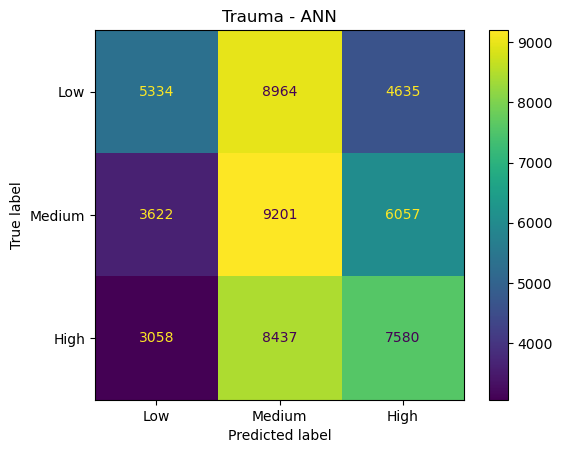

trauma_uk catboost-ve
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([23227, 20152, 13509]))
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([19035, 18958, 18895]))


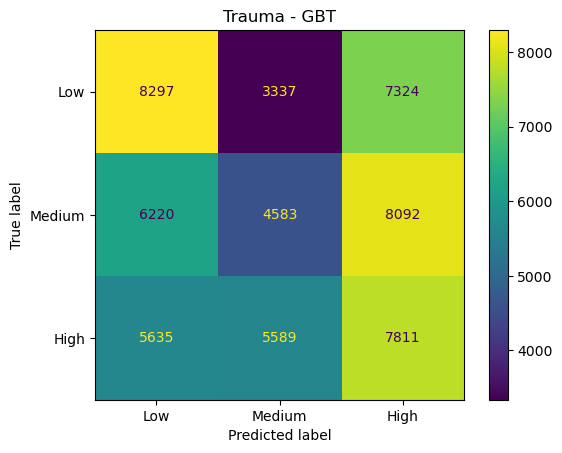

diabetes NN-dropout
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([212, 205, 351]))
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([271, 266, 231]))


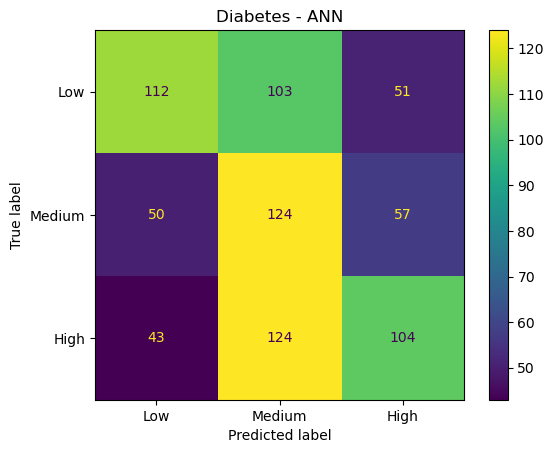

diabetes catboost-ve
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([150, 206, 412]))
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([284, 230, 254]))


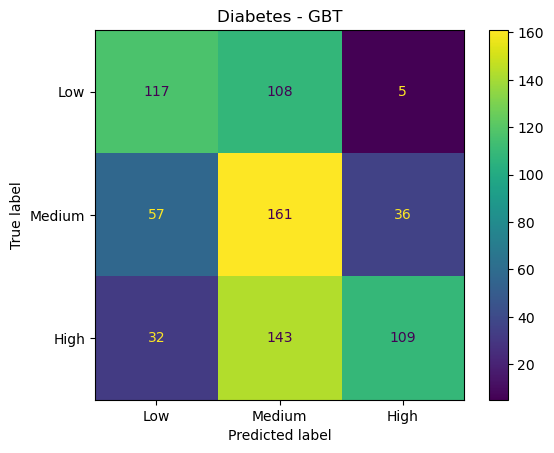

critical_outcome NN-dropout
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([ 66998,  92160, 282279]))
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([147353, 147269, 146815]))


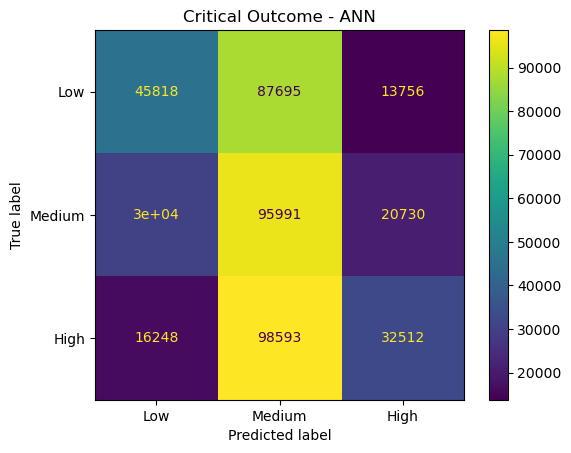

critical_outcome catboost-ve
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([  4591,  51970, 384876]))
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([147344, 147049, 147044]))


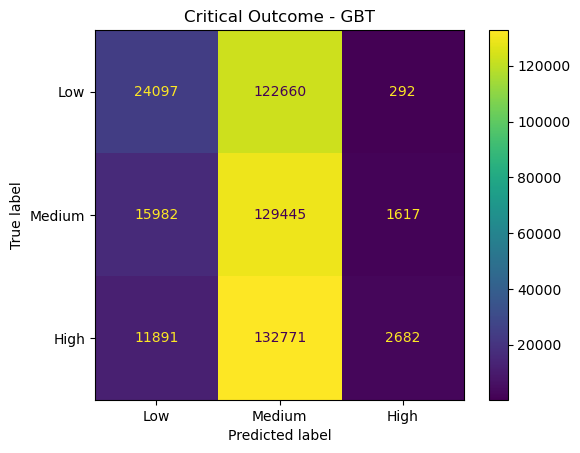

ED_3day_readmit NN-dropout
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([222846, 108028, 110563]))
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([147420, 147288, 146729]))


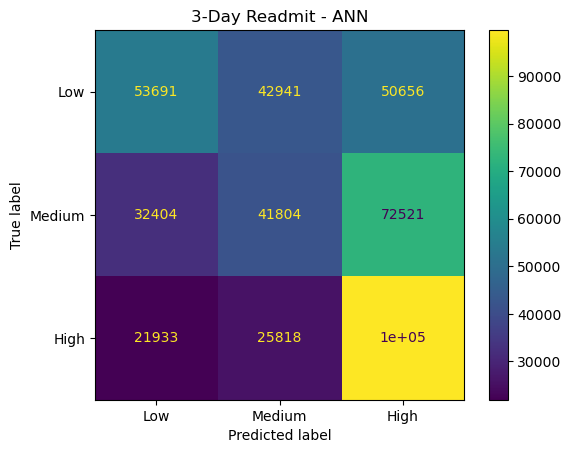

ED_3day_readmit catboost-ve
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([196310, 100135, 144992]))
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([147161, 146913, 147363]))


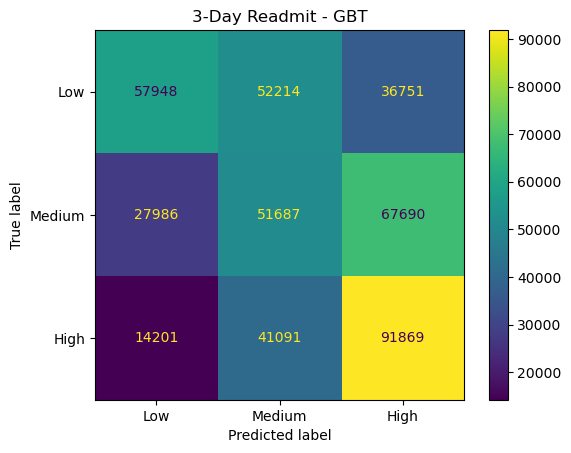

hospitalization_prediction NN-dropout
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([129151, 121553, 190733]))
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([147246, 147167, 147024]))


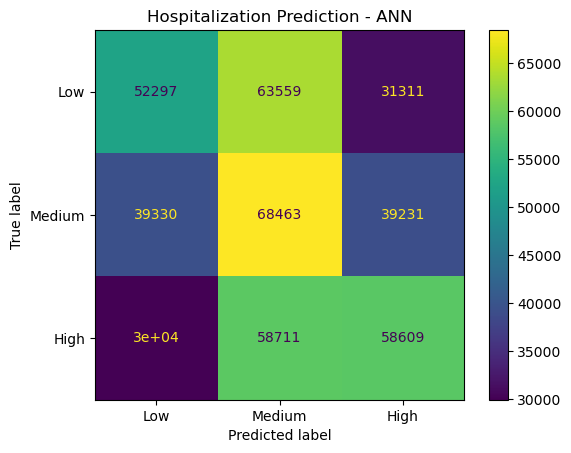

hospitalization_prediction catboost-ve
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([138473,  81311, 221653]))
(array(['High', 'Low', 'Medium'], dtype='<U6'), array([147215, 146802, 147420]))


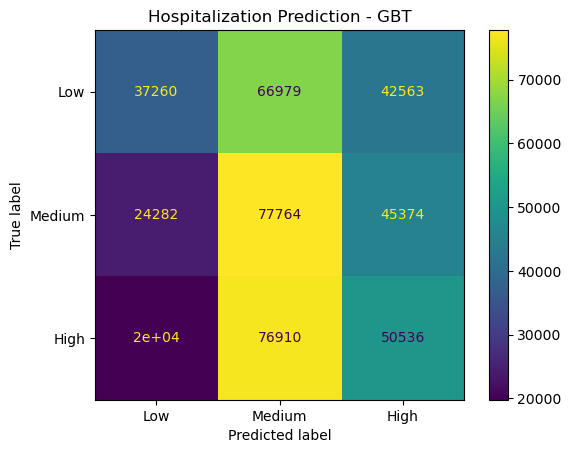

In [6]:
# Table 4
results = []
for dataset, model in eval_combos:
    print(dataset, model)
    r = compute_format_row_table_3_4(dataset, model, 3, res_key = res_key)
    results.append(r)
results = pd.DataFrame(results)
display(results)
results.to_csv(f"RQ 3/results/{res_key}/bin_accuracy_nbins3.csv")
for dataset, model in eval_combos:
    print(dataset, model)
    _confusion_matrix(dataset, model, 3, res_key)

Code to produce bin assignment accuracy/tree complexity trade-off charts
- No. subgroups vs bin assignment accuracy 
- max rule len vs bin assignment accuracy
Need to average across 10-fold CV

In [7]:
# def read_tuning_file(dataset, model, iteration, n_bins, res_key = ""):
#     if res_key != "":
#         fn = f"RQ 3/results/{res_key}/DTTuning_{dataset}_{model}_{iteration}_nbins{n_bins}.csv"
#     else:
#         fn = f"RQ 3/results/DTTuning_{dataset}_{model}_{iteration}_nbins{n_bins}.csv"
#     return pd.read_csv(fn)

# def tradeoff_noavg(tune_df, x_col, y_col):
#     tune_df_ = tune_df.sort_values(by=x_col, ascending=True)
#     plt.plot(tune_df_[x_col], tune_df_[y_col])
#     plt.xlabel(map_col_names_axis_names(x_col))
#     plt.ylabel(map_col_names_axis_names(y_col))
#     plt.show()
    
# def map_col_names_axis_names(name):
#     map_ = {
#         "num_subgroups": "Number of Subgroups (equiv. Number of Leaves)",
#         "score": "Validation Set Accuracy",
#         "max rule len": "Maximum Rule Length (equiv. Tree Depth)"
#     }
#     return map_[name]

In [8]:
# def tradeoff_avg(x_col, y_col, dataset, model, n_bins, res_key = ""):
#     xs, ys = [], []
#     mean_x_axis = []
#     for i in range(10):
#         # print(i)
#         df = read_tuning_file(dataset, model, i, 2, res_key = res_key)   
#         df.sort_values(by=x_col, ascending=True, inplace=True)
#         x_ = df[x_col]
#         y_ = df[y_col]
#         mean_x_axis.extend(x_)
#         xs.append(x_)
#         ys.append(y_)
    
#     mean_x_axis = np.unique(np.asarray(mean_x_axis))
#     new_ys = []
#     for i in range(len(xs)):
#         # print(i)
#         # print(xs[i], ys[i])
#         _y_ = np.interp(mean_x_axis,xs[i], ys[i])
#         new_ys.append(_y_)
#     mean_y_axis = np.mean(new_ys, axis=0)
#     print(mean_x_axis.shape, mean_y_axis.shape)
#     # plt.plot(mean_x_axis, mean_y_axis)
#     xname = map_col_names_axis_names(x_col)
#     yname = map_col_names_axis_names(y_col)
#     data_name = map_dataset_names_proper(dataset)
#     mdl_name = map_model_names_proper(model)
#     # plt.xlabel(f"{xname}")
#     # plt.ylabel(f"Average {yname}")
#     # plt.title(f"{mdl_name} - {data_name}")
#     # plt.savefig(f"RQ 3/results/{res_key}/tuning_{dataset}_{model}_{x_col}_nbins{n_bins}.png")
#     # plt.show()
#     res = pd.DataFrame({"x": mean_x_axis, "y": mean_y_axis})
#     res.to_csv(f"RQ 3/results/{res_key}/tradeoff_{x_col}_{y_col}_{dataset}_{model}_bins{n_bins}.csv")
#     return {"x": mean_x_axis, "y": mean_y_axis}


In [9]:
# to_plot_ann = {}
# to_plot_gbt = {}
# for dataset, model in eval_combos:
#     print(f"======{dataset} {model}======")
#     res = tradeoff_avg("num_subgroups", "score", dataset ,model, 2, res_key = res_key)
#     dataset_fm = map_dataset_names_proper(dataset)
#     if model == "NN-dropout":
#         to_plot_ann[f"{dataset_fm}"] = res
#     elif model == "catboost-ve":
#         to_plot_gbt[f"{dataset_fm}"] = res
#     # tradeoff_avg("max rule len", "score", dataset, model, 2, res_key = res_key)
    
# x_col = "num_subgroups"
# y_col = "score"
# def combine_plots(x_col, y_col, to_plot, mdl_name, res_key, n_bins):
#     for key in to_plot:
#         x = to_plot[key]["x"]
#         y = to_plot[key]["y"]    
#         plt.plot(x, y, label=key)


#     xname = map_col_names_axis_names("num_subgroups")
#     yname = map_col_names_axis_names("score")
#     data_name = map_dataset_names_proper(dataset)
#     mdl_name = map_model_names_proper(mdl_name)
#     plt.xlabel(f"{xname}")
#     plt.ylabel(f"Average {yname}")
#     plt.legend()
#     plt.title(mdl_name)
#     plt.savefig(f"RQ 3/results/{res_key}/tuning_{mdl_name}_{x_col}_{y_col}_nbins{n_bins}.png")
#     plt.show() 

# combine_plots(x_col, y_col, to_plot_ann, "NN-dropout", res_key,2)
# combine_plots(x_col, y_col, to_plot_gbt, "catboost-ve", res_key,2)

======trauma_uk NN-dropout======


FileNotFoundError: [Errno 2] No such file or directory: 'RQ 3/results/dissertation_SG/DTTuning_trauma_uk_NN-dropout_0_nbins2.csv'

Code to perform statistical signifance test between weighted averages from subgroups associated with uncertainty level 0 and uncertainty level 1

In [16]:
def convert_df_bin_count_to_bin_predicted(count_string):
    #count_string = "Counter({0:X, 1:Y})"
    print(f"count_string: {count_string}")
    res = np.zeros(shape=3)
    count_string = count_string[1:]
    count_string = count_string[:-1]
    print(count_string)
    counts = count_string.split(",")
    for str_i in counts:
        str_i = str_i.split(":")
        try:
            i = int(str_i[0])
            v = int(str_i[1])
            res[i] = v
        except:
            return np.nan
    return np.argmax(res)

In [21]:
def prep_weighted_data_for_R_3bins(model, dataset, res_key=""):
    stats_df = read_stats_file(model, dataset, res_key = res_key)
    trees_df = stats_df[(stats_df["n_bins"]==3) & ( stats_df["alpha_gain"] == alpha_gain) & (stats_df["min_support"] == 1)] 
    print(trees_df.shape)
    subgroup_0_acc = []
    subgroup_0_coverage = []
    subgroup_1_acc = []
    subgroup_1_coverage = []
    subgroup_2_acc = []
    subgroup_2_coverage = []
    for i in range(trees_df.shape[0]):
        tree = trees_df.iloc[i]
        print(tree)
        num_subg = int(tree["no_rules"])
        tree_sizes = tree[[f"subgroup {s} size" for s in range(num_subg)]].values
        total_recs = np.sum(tree_sizes)
        print(tree_sizes)
        print(i, num_subg)
        for j in range(num_subg):
            print(j)
            count_string = tree[f"subgroup {j} uncertainty bin distribution"]
            if pd.isnull(count_string): continue
            idx = convert_df_bin_count_to_bin_predicted(count_string)
            print(count_string, idx)
            if idx == 0:
                acc_key = f"subgroup {j} classsification accuracy"
                cov_key = f"subgroup {j} size"
                subgroup_0_acc.append(tree[acc_key])
                subgroup_0_coverage.append(tree[cov_key]/total_recs)
            elif idx == 1:
                acc_key = f"subgroup {j} classsification accuracy"
                cov_key = f"subgroup {j} size"
                subgroup_1_acc.append(tree[acc_key])
                subgroup_1_coverage.append(tree[cov_key]/total_recs)
            elif idx == 2:
                acc_key = f"subgroup {j} classsification accuracy"
                cov_key = f"subgroup {j} size"
                subgroup_2_acc.append(tree[acc_key])
                subgroup_2_coverage.append(tree[cov_key]/total_recs)
            else:
                print("!!! Something terrible has happend: ", idx)
    print(len(subgroup_0_acc), len(subgroup_0_coverage), len(subgroup_1_acc), len(subgroup_1_coverage), len(subgroup_2_acc), len(subgroup_2_coverage))
    df = {
        "subgroup_0_accuracy": subgroup_0_acc,
        "subgroup_0_coverage": subgroup_0_coverage,
        "subgroup_1_accuracy": subgroup_1_acc,
        "subgroup_1_coverage": subgroup_1_coverage,
        "subgroup_2_accuracy": subgroup_2_acc,
        "subgroup_2_coverage": subgroup_2_coverage,
    }
    df = pd.DataFrame.from_dict(df, orient='index').transpose()
    df.to_csv(f"RQ 3/results/{res_key}/R_input_{model}_{dataset}_3bins.csv")
    
def prep_weighted_data_for_R(model, dataset, res_key=""):
    stats_df = read_stats_file(model, dataset, res_key = res_key)
    trees_df = stats_df[(stats_df["n_bins"]==2) & ( stats_df["alpha_gain"] == alpha_gain) & (stats_df["min_support"] == 1)] 
    print(trees_df.shape)
    subgroup_0_acc = []
    subgroup_0_coverage = []
    subgroup_1_acc = []
    subgroup_1_coverage = []
    for i in range(trees_df.shape[0]):
        tree = trees_df.iloc[i]
        print(tree)
        num_subg = int(tree["no_rules"])
        tree_sizes = tree[[f"subgroup {s} size" for s in range(num_subg)]].values
        total_recs = np.sum(tree_sizes)
        print(tree_sizes)
        print(i, num_subg)
        for j in range(num_subg):
            print(j)
            count_string = tree[f"subgroup {j} uncertainty bin distribution"]
            idx = convert_df_bin_count_to_bin_predicted(count_string)
            print(count_string, idx)
            if idx == 0:
                acc_key = f"subgroup {j} classsification accuracy"
                cov_key = f"subgroup {j} size"
                subgroup_0_acc.append(tree[acc_key])
                subgroup_0_coverage.append(tree[cov_key]/total_recs)
            elif idx == 1:
                acc_key = f"subgroup {j} classsification accuracy"
                cov_key = f"subgroup {j} size"
                subgroup_1_acc.append(tree[acc_key])
                subgroup_1_coverage.append(tree[cov_key]/total_recs)
            else:
                print("!!! Something terrible has happend: ", idx)
    print(len(subgroup_0_acc), len(subgroup_0_coverage), len(subgroup_1_acc), len(subgroup_1_coverage))
    df = {
        "subgroup_0_accuracy": subgroup_0_acc,
        "subgroup_0_coverage": subgroup_0_coverage,
        "subgroup_1_accuracy": subgroup_1_acc,
        "subgroup_1_coverage": subgroup_1_coverage,
    }
    df = pd.DataFrame.from_dict(df, orient='index').transpose()
    df.to_csv(f"RQ 3/results/{res_key}/R_input_{model}_{dataset}.csv")
              
              
# prep_weighted_data_for_R("NN-dropout", "trauma_uk", res_key=res_key)              
    

In [22]:
import subprocess

for dataset, model in eval_combos:
    print(f"======{dataset} {model}======")
    prep_weighted_data_for_R(model, dataset, res_key=res_key)
    prep_weighted_data_for_R_3bins(model, dataset, res_key=res_key)
    # print(f"Rscript RQ 3/WeightedTTest.R {dataset} {model} {res_key}")
    # res = subprocess.check_output(f"Rscript RQ\ 3/WeightedTTest.R {dataset} {model} {res_key}", shell=True)


======trauma_uk NN-dropout======
(10, 1449)
Unnamed: 0                                                 4
dataset                                            trauma_uk
model                                             NN-dropout
train_test                                              test
iteration                                                  0
                                                     ...    
subgroup 158 uncertainty range                           NaN
subgroup 158 uncertainty assignment accuracy             NaN
subgroup 158 classsification accuracy                    NaN
subgroup 158 uncertainty bin distribution                NaN
subgroup 158 true uncertainty bin distribution           NaN
Name: 4, Length: 1449, dtype: object
[924.0 1736.0 475.0 309.0 129.0 232.0 304.0 51.0 102.0 23.0 11.0 51.0
 114.0 64.0 67.0 124.0 65.0 66.0 33.0 16.0 123.0 29.0 23.0 64.0 76.0]
0 25
0
count_string: {0: 276, 1: 648}
0: 276, 1: 648
{0: 276, 1: 648} 1
1
count_string: {0: 1184, 1: 552}
0:

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (5569,5570,5578,5579,5587,5588,5596,5597,5605,5606,5614,5615,5623,5624,5632,5633,5641,5642,5650,5651,5659,5660,5668,5669,5677,5678,5686,5687,5695,5696,5704,5705,5713,5714,5722,5723,5731,5732,5740,5741,5749,5750,5758,5759,5767,5768,5776,5777,5785,5786,5794,5795,5803,5804,5812,5813,5821,5822,5830,5831,5839,5840,5848,5849,5857,5858,5866,5867,5875,5876,5884,5885,5893,5894,5902,5903,5911,5912,5920,5921) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


(10, 5922)
Unnamed: 0                                                       4
dataset                                           critical_outcome
model                                                   NN-dropout
train_test                                                    test
iteration                                                        0
                                                        ...       
subgroup 655 uncertainty range                                 NaN
subgroup 655 uncertainty assignment accuracy                   NaN
subgroup 655 classsification accuracy                          NaN
subgroup 655 uncertainty bin distribution                      NaN
subgroup 655 true uncertainty bin distribution                 NaN
Name: 4, Length: 5922, dtype: object
[10940.0 7868.0 888.0 4695.0 1106.0 1123.0 1757.0 642.0 582.0 282.0 367.0
 461.0 192.0 287.0 452.0 150.0 256.0 136.0 214.0 386.0 738.0 268.0 104.0
 142.0 194.0 128.0 335.0 138.0 73.0 283.0 97.0 178.0 203.0 142.0 122

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (5569,5570,5578,5579,5587,5588,5596,5597,5605,5606,5614,5615,5623,5624,5632,5633,5641,5642,5650,5651,5659,5660,5668,5669,5677,5678,5686,5687,5695,5696,5704,5705,5713,5714,5722,5723,5731,5732,5740,5741,5749,5750,5758,5759,5767,5768,5776,5777,5785,5786,5794,5795,5803,5804,5812,5813,5821,5822,5830,5831,5839,5840,5848,5849,5857,5858,5866,5867,5875,5876,5884,5885,5893,5894,5902,5903,5911,5912,5920,5921) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


(10, 5922)
Unnamed: 0                                                       5
dataset                                           critical_outcome
model                                                   NN-dropout
train_test                                                    test
iteration                                                        0
                                                        ...       
subgroup 655 uncertainty range                                 NaN
subgroup 655 uncertainty assignment accuracy                   NaN
subgroup 655 classsification accuracy                          NaN
subgroup 655 uncertainty bin distribution                      NaN
subgroup 655 true uncertainty bin distribution                 NaN
Name: 5, Length: 5922, dtype: object
[10940.0 7437.0 888.0 4282.0 4113.0 5617.0 1660.0 2989.0 394.0 525.0
 1317.0 817.0 1006.0 320.0 138.0 185.0 373.0 159.0 47.0 86.0 50.0 13.0
 56.0 52.0 67.0 115.0 11.0 37.0 109.0 144.0 35.0 12.0]
0 32
0
count_string:

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (6361,6362,6370,6371,6379,6380,6388,6389,6397,6398,6406,6407,6415,6416,6424,6425,6433,6434,6442,6443,6451,6452,6460,6461,6469,6470,6478,6479,6487,6488,6496,6497,6505,6506,6514,6515,6523,6524,6532,6533,6541,6542,6550,6551,6559,6560,6568,6569,6577,6578,6586,6587,6595,6596,6604,6605,6613,6614,6622,6623,6631,6632,6640,6641,6649,6650,6658,6659,6667,6668,6676,6677,6685,6686,6694,6695) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


(10, 6696)
Unnamed: 0                                                       4
dataset                                           critical_outcome
model                                                  catboost-ve
train_test                                                    test
iteration                                                        0
                                                        ...       
subgroup 741 uncertainty range                                 NaN
subgroup 741 uncertainty assignment accuracy                   NaN
subgroup 741 classsification accuracy                          NaN
subgroup 741 uncertainty bin distribution                      NaN
subgroup 741 true uncertainty bin distribution                 NaN
Name: 4, Length: 6696, dtype: object
[13227.0 11354.0 590.0 1239.0 1464.0 2088.0 552.0 352.0 414.0 672.0 225.0
 144.0 255.0 211.0 358.0 145.0 98.0 367.0 535.0 247.0 59.0 321.0 88.0
 184.0 85.0 153.0 414.0 202.0 140.0 110.0 78.0 285.0 85.0 51.0 53.0 156

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (6361,6362,6370,6371,6379,6380,6388,6389,6397,6398,6406,6407,6415,6416,6424,6425,6433,6434,6442,6443,6451,6452,6460,6461,6469,6470,6478,6479,6487,6488,6496,6497,6505,6506,6514,6515,6523,6524,6532,6533,6541,6542,6550,6551,6559,6560,6568,6569,6577,6578,6586,6587,6595,6596,6604,6605,6613,6614,6622,6623,6631,6632,6640,6641,6649,6650,6658,6659,6667,6668,6676,6677,6685,6686,6694,6695) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


(10, 6696)
Unnamed: 0                                                       5
dataset                                           critical_outcome
model                                                  catboost-ve
train_test                                                    test
iteration                                                        0
                                                        ...       
subgroup 741 uncertainty range                                 NaN
subgroup 741 uncertainty assignment accuracy                   NaN
subgroup 741 classsification accuracy                          NaN
subgroup 741 uncertainty bin distribution                      NaN
subgroup 741 true uncertainty bin distribution                 NaN
Name: 5, Length: 6696, dtype: object
[10940.0 7868.0 5937.0 5001.0 8183.0 1402.0 169.0 1447.0 457.0 1976.0
 217.0 547.0]
0 12
0
count_string: {1: 10940}
1: 10940
{1: 10940} 1
1
count_string: {1: 7868}
1: 7868
{1: 7868} 1
2
count_string: {1: 5937}
1: 59

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (4606,4607,4615,4616,4624,4625,4633,4634,4642,4643,4651,4652,4660,4661,4669,4670,4678,4679,4687,4688,4696,4697,4705,4706,4714,4715,4723,4724,4732,4733,4741,4742,4750,4751,4759,4760,4768,4769,4777,4778,4786,4787,4795,4796,4804,4805,4813,4814,4822,4823,4831,4832,4840,4841,4849,4850,4858,4859,4867,4868,4876,4877,4885,4886,4894,4895,4903,4904,4912,4913,4921,4922,4930,4931,4939,4940,4948,4949,4957,4958,4966,4967,4975,4976,4984,4985) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


(10, 4986)
Unnamed: 0                                                      4
dataset                                           ED_3day_readmit
model                                                  NN-dropout
train_test                                                   test
iteration                                                       0
                                                       ...       
subgroup 551 uncertainty range                                NaN
subgroup 551 uncertainty assignment accuracy                  NaN
subgroup 551 classsification accuracy                         NaN
subgroup 551 uncertainty bin distribution                     NaN
subgroup 551 true uncertainty bin distribution                NaN
Name: 4, Length: 4986, dtype: object
[4393.0 3997.0 1230.0 379.0 1813.0 711.0 368.0 118.0 208.0 373.0 111.0
 505.0 622.0 986.0 421.0 1985.0 719.0 89.0 475.0 311.0 733.0 96.0 372.0
 304.0 645.0 170.0 244.0 1127.0 244.0 276.0 479.0 250.0 201.0 151.0 172.0
 135.0 14

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (4606,4607,4615,4616,4624,4625,4633,4634,4642,4643,4651,4652,4660,4661,4669,4670,4678,4679,4687,4688,4696,4697,4705,4706,4714,4715,4723,4724,4732,4733,4741,4742,4750,4751,4759,4760,4768,4769,4777,4778,4786,4787,4795,4796,4804,4805,4813,4814,4822,4823,4831,4832,4840,4841,4849,4850,4858,4859,4867,4868,4876,4877,4885,4886,4894,4895,4903,4904,4912,4913,4921,4922,4930,4931,4939,4940,4948,4949,4957,4958,4966,4967,4975,4976,4984,4985) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


(10, 4986)
Unnamed: 0                                                      5
dataset                                           ED_3day_readmit
model                                                  NN-dropout
train_test                                                   test
iteration                                                       0
                                                       ...       
subgroup 551 uncertainty range                                NaN
subgroup 551 uncertainty assignment accuracy                  NaN
subgroup 551 classsification accuracy                         NaN
subgroup 551 uncertainty bin distribution                     NaN
subgroup 551 true uncertainty bin distribution                NaN
Name: 5, Length: 4986, dtype: object
[4393.0 3550.0 504.0 505.0 1042.0 1840.0 3154.0 3465.0 398.0 3045.0 469.0
 242.0 203.0 888.0 116.0 251.0 83.0 65.0 202.0 329.0 277.0 1501.0 2239.0
 757.0 528.0 269.0 118.0 205.0 1063.0 218.0 354.0 273.0 86.0 113.0 512.0
 1230.

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (19,20,28,29,37,38,46,47,55,56,64,65,73,74,82,83,91,92,100,101,109,110,118,119,127,128,136,137,145,146,154,155,163,164,172,173,181,182,190,191,199,200,208,209,217,218,226,227,235,236,244,245,253,254,262,263,271,272,280,281,289,290,298,299,313,314,322,323,331,332,340,341,349,350,358,359,367,368,376,377,385,386,394,395,403,404,412,413,421,422,430,431,439,440,448,449,457,458,466,467,475,476,484,485,493,494,502,503,511,512,520,521,529,530,538,539,547,548,556,557,565,566,574,575,583,584,592,593,601,602,610,611,619,620,628,629,637,638,646,647,655,656,664,665,673,674,682,683,691,692,700,701,709,710,718,719,727,728,736,737,745,746,754,755,763,764,772,773,781,782,790,791,799,800,808,809,817,818,826,827,835,836,844,845,853,854,862,863,871,872,880,881,889,890,898,899,907,908,916,917,925,926,934,935,943,944,952,953,961,962,970,971,979,980,988,989,997,998,1006,1007,1015,1016,1024,1025,1033,1034,1042,1043,1051,1052,1060,1061,1069,1070,1078,1

(10, 8334)
Unnamed: 0                                                      4
dataset                                           ED_3day_readmit
model                                                 catboost-ve
train_test                                                   test
iteration                                                       0
                                                       ...       
subgroup 923 uncertainty range                                NaN
subgroup 923 uncertainty assignment accuracy                  NaN
subgroup 923 classsification accuracy                         NaN
subgroup 923 uncertainty bin distribution                     NaN
subgroup 923 true uncertainty bin distribution                NaN
Name: 4, Length: 8334, dtype: object
[4976.0 6804.0 2887.0 935.0 1461.0 433.0 839.0 2374.0 1946.0 371.0 887.0
 311.0 591.0 845.0 459.0 348.0 286.0 213.0 154.0 278.0 265.0 616.0 439.0
 137.0 271.0 130.0 203.0 109.0 201.0 158.0 107.0 233.0 179.0 528.0 448.0
 220.0 

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (19,20,28,29,37,38,46,47,55,56,64,65,73,74,82,83,91,92,100,101,109,110,118,119,127,128,136,137,145,146,154,155,163,164,172,173,181,182,190,191,199,200,208,209,217,218,226,227,235,236,244,245,253,254,262,263,271,272,280,281,289,290,298,299,313,314,322,323,331,332,340,341,349,350,358,359,367,368,376,377,385,386,394,395,403,404,412,413,421,422,430,431,439,440,448,449,457,458,466,467,475,476,484,485,493,494,502,503,511,512,520,521,529,530,538,539,547,548,556,557,565,566,574,575,583,584,592,593,601,602,610,611,619,620,628,629,637,638,646,647,655,656,664,665,673,674,682,683,691,692,700,701,709,710,718,719,727,728,736,737,745,746,754,755,763,764,772,773,781,782,790,791,799,800,808,809,817,818,826,827,835,836,844,845,853,854,862,863,871,872,880,881,889,890,898,899,907,908,916,917,925,926,934,935,943,944,952,953,961,962,970,971,979,980,988,989,997,998,1006,1007,1015,1016,1024,1025,1033,1034,1042,1043,1051,1052,1060,1061,1069,1070,1078,1

(10, 8334)
Unnamed: 0                                                      5
dataset                                           ED_3day_readmit
model                                                 catboost-ve
train_test                                                   test
iteration                                                       0
                                                       ...       
subgroup 923 uncertainty range                                NaN
subgroup 923 uncertainty assignment accuracy                  NaN
subgroup 923 classsification accuracy                         NaN
subgroup 923 uncertainty bin distribution                     NaN
subgroup 923 true uncertainty bin distribution                NaN
Name: 5, Length: 8334, dtype: object
[4630.0 4985.0 2107.0 5613.0 8855.0 1654.0 1629.0 558.0 870.0 772.0 1496.0
 1246.0 684.0 399.0 130.0 684.0 351.0 382.0 300.0 169.0 218.0 742.0 344.0
 126.0 158.0 269.0 353.0 201.0 609.0 133.0 86.0 247.0 57.0 155.0 98.0
 158.0 

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (3319,3320,3328,3329,3337,3338,3346,3347,3355,3356,3364,3365,3373,3374,3382,3383,3391,3392,3400,3401,3409,3410,3418,3419,3427,3428,3436,3437,3445,3446,3454,3455,3463,3464,3472,3473,3481,3482,3490,3491,3499,3500,3508,3509,3517,3518,3526,3527,3535,3536,3544,3545,3553,3554,3562,3563,3571,3572,3580,3581,3589,3590,3598,3599,3607,3608,3616,3617,3625,3626,3634,3635,3643,3644,3652,3653,3661,3662,3670,3671,3679,3680,3688,3689,3697,3698,3706,3707,3715,3716,3724,3725,3733,3734,3742,3743,3751,3752,3760,3761,3769,3770,3778,3779,3787,3788,3796,3797,3805,3806,3814,3815,3823,3824,3832,3833,3841,3842,3850,3851,3859,3860,3868,3869) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


(10, 3870)
Unnamed: 0                                                                 4
dataset                                           hospitalization_prediction
model                                                             NN-dropout
train_test                                                              test
iteration                                                                  0
                                                             ...            
subgroup 427 uncertainty range                                           NaN
subgroup 427 uncertainty assignment accuracy                             NaN
subgroup 427 classsification accuracy                                    NaN
subgroup 427 uncertainty bin distribution                                NaN
subgroup 427 true uncertainty bin distribution                           NaN
Name: 4, Length: 3870, dtype: object
[1706.0 2360.0 1131.0 154.0 337.0 2560.0 558.0 2134.0 922.0 3034.0 317.0
 621.0 36.0 313.0 346.0 350.0 25

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (3319,3320,3328,3329,3337,3338,3346,3347,3355,3356,3364,3365,3373,3374,3382,3383,3391,3392,3400,3401,3409,3410,3418,3419,3427,3428,3436,3437,3445,3446,3454,3455,3463,3464,3472,3473,3481,3482,3490,3491,3499,3500,3508,3509,3517,3518,3526,3527,3535,3536,3544,3545,3553,3554,3562,3563,3571,3572,3580,3581,3589,3590,3598,3599,3607,3608,3616,3617,3625,3626,3634,3635,3643,3644,3652,3653,3661,3662,3670,3671,3679,3680,3688,3689,3697,3698,3706,3707,3715,3716,3724,3725,3733,3734,3742,3743,3751,3752,3760,3761,3769,3770,3778,3779,3787,3788,3796,3797,3805,3806,3814,3815,3823,3824,3832,3833,3841,3842,3850,3851,3859,3860,3868,3869) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


(10, 3870)
Unnamed: 0                                                                 5
dataset                                           hospitalization_prediction
model                                                             NN-dropout
train_test                                                              test
iteration                                                                  0
                                                             ...            
subgroup 427 uncertainty range                                           NaN
subgroup 427 uncertainty assignment accuracy                             NaN
subgroup 427 classsification accuracy                                    NaN
subgroup 427 uncertainty bin distribution                                NaN
subgroup 427 true uncertainty bin distribution                           NaN
Name: 5, Length: 3870, dtype: object
[1706.0 2360.0 277.0 889.0 1623.0 5139.0 833.0 652.0 1022.0 2646.0 192.0
 1399.0 4274.0 676.0 322.0 157.0

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (4822,4823,4831,4832,4840,4841,4849,4850,4858,4859,4867,4868,4876,4877,4885,4886,4894,4895,4903,4904,4912,4913,4921,4922,4930,4931,4939,4940,4948,4949,4957,4958,4966,4967,4975,4976,4984,4985,4993,4994,5002,5003,5011,5012) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


(10, 5013)
Unnamed: 0                                                                 4
dataset                                           hospitalization_prediction
model                                                            catboost-ve
train_test                                                              test
iteration                                                                  0
                                                             ...            
subgroup 554 uncertainty range                                           NaN
subgroup 554 uncertainty assignment accuracy                             NaN
subgroup 554 classsification accuracy                                    NaN
subgroup 554 uncertainty bin distribution                                NaN
subgroup 554 true uncertainty bin distribution                           NaN
Name: 4, Length: 5013, dtype: object
[4690.0 1345.0 767.0 2997.0 834.0 1421.0 332.0 986.0 1054.0 1082.0 2213.0
 3614.0 706.0 425.0 209.0 999.0

/tmp/ipykernel_4523/3778518647.py:3: DtypeWarning: Columns (4822,4823,4831,4832,4840,4841,4849,4850,4858,4859,4867,4868,4876,4877,4885,4886,4894,4895,4903,4904,4912,4913,4921,4922,4930,4931,4939,4940,4948,4949,4957,4958,4966,4967,4975,4976,4984,4985,4993,4994,5002,5003,5011,5012) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{cls_model}_{dataset}.csv")


In [ ]:
for dataset, model in eval_combos:
    print(f"weighted_ttest(\"{dataset}\", \"{model}\", args[1])")